In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from swap_auditor import NaiveSwapAuditor

In [2]:
nels = pd.read_csv('data/NELS_Filtered.csv')
nels_columns = pd.read_csv('data/NELS_Subset_Columns.csv')
nels_columns_readable = pd.read_csv('data/NELS_Subset_Columns_Human_Readable.csv')
nels_subset = nels[list(nels_columns.columns)]
nels_subset.columns = list(nels_columns_readable.columns)

In [3]:
# Add 1st/2nd gen immigrant status 
# Native/non native english speaker

target_col = "GradesUndergrad" # Grades
nels_valid_grades = nels_subset[(1 <= nels_subset[target_col]) & (nels_subset[target_col] <= 7)]

# Make binary decision >= 2.75 GPA
nels_valid_grades[target_col] = np.where(nels_valid_grades[target_col] <= 3, 1, 0)

# Shuffle randomly before training models
nels_valid_grades = nels_valid_grades.sample(frac=1).reset_index(drop=True)

# Withhold columns that are improper for prediction (like having completed PSE)
columns_to_withhold = ["Degree", 
"StudentId", 
"HighestPostSecondaryEducationAttained", 
"AttendedFirstChoicePostSecondaryEducation",
"JobSatisfaction", 
"Income",
"TotalEarningsJob1",
"TotalEarningsJob2",
"CoursesAt2To4YearCollege"]

nels_valid_grades = nels_valid_grades[nels_valid_grades.columns.difference(columns_to_withhold)]

X = nels_valid_grades[nels_valid_grades.columns.difference([target_col])]
y = nels_valid_grades[target_col]

C:\Users\Eliza\AppData\Local\Temp\ipykernel_1588\88887000.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nels_valid_grades[target_col] = np.where(nels_valid_grades[target_col] <= 3, 1, 0)


In [4]:
# Run this cell to downsample
from sklearn.utils import resample
def resample_up_down(dataframe, upsample=True, target_col=target_col):
    # Separate majority and minority classes
    df_majority = dataframe[dataframe[target_col]==1]
    df_minority = dataframe[dataframe[target_col]==0]
    
    if upsample:
        # Upsample minority class
        df_minority_upsampled = resample(df_minority, 
                                        replace=True,
                                        n_samples=len(df_majority),
                                        random_state=0)
    
        # Combine majority class with upsampled minority class
        df_resampled = pd.concat([df_majority, df_minority_upsampled])
    else:
        # Downsample majority class
        df_majority_downsampled = resample(df_majority, 
                                        replace=False,
                                        n_samples=len(df_minority),
                                        random_state=0) 
        
        # Combine minority class with downsampled majority class
        df_resampled = pd.concat([df_majority_downsampled, df_minority])
        
    # Display new class counts
    print(df_resampled[target_col].value_counts())

    return df_resampled

nels_valid_grades = resample_up_down(nels_valid_grades, upsample=True, target_col=target_col)
X = nels_valid_grades.loc[:, nels_valid_grades.columns != target_col]
y = nels_valid_grades[target_col]  

1    6640
0    6640
Name: GradesUndergrad, dtype: int64


In [5]:
def return_real_column_name(human, human_list, yucky_list):
    return yucky_list[human_list.index(human)]

human_list = nels_columns_readable.columns.tolist()
yucky_list = nels_columns.columns.tolist()
return_real_column_name('Race', human_list, yucky_list)

'F4RACEM'

In [6]:
toy_columns = ['StudentId',
# .66 Acc RF
'Sex',
'Race',
'CompositeGrades',
'StandardizedTestQuartile',
'CategoricalGrades',

# .86 Acc RF (with base), .96 (second two), .58 (alone)
'TimeSpentOnHomeworkInSchool',
'TimeSpentOnHomeworkOutOfSchool',
'TimeSpentOnExtracurriculars',
'HelpWithEssays',
'ParentsCheckHomework',

# .92 Acc FR (with base), .82 (alone)
'HighSchoolHelpedWithSchoolApplication',
'HelpedWithFinancialAidApp',
'ParentsHighestLevelEducation',
'Socio-economicStatusQuartile',
'PrivateSchoolExpenses',
'PrivateTutoringExpenses',
'Tutored',
'FathersWishes',
'MothersWishes',

'GradesUndergrad']

In [7]:
# Only valid grades
toy_dataframe = nels_subset[(1 <= nels_subset[target_col]) & (nels_subset[target_col] <= 7)]

# Only white/black nonhispanic
toy_dataframe = toy_dataframe[(3 <= toy_dataframe['Race']) & (toy_dataframe['Race'] <= 4)]

# Shuffle randomly before training models
toy_dataframe = toy_dataframe.sample(frac=1).reset_index(drop=True)

toy_dataframe = toy_dataframe[toy_columns]

# Make binary decision >= 2.75 GPA
toy_dataframe[target_col] = np.where(toy_dataframe[target_col] <= 3, 1, 0)
make_string = False

if make_string:
    # Make binary decision >= 2.75 GPA
    toy_dataframe["Race"] = np.where(toy_dataframe["Race"] == 3, "Black", "White")
    toy_dataframe["Sex"] = np.where(toy_dataframe["Sex"] == 1, "Male", "Female")

toy_dataframe = resample_up_down(toy_dataframe, upsample=True, target_col=target_col)

# Withhold columns that are improper for prediction (like having completed PSE)
columns_to_withhold = ["StudentId"]

X = toy_dataframe[toy_dataframe.columns.difference([target_col]+columns_to_withhold)]
y = toy_dataframe[target_col]

1    5154
0    5154
Name: GradesUndergrad, dtype: int64


In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rf = RandomForestClassifier() # max_iter=1000 
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

print(classification_report(y_test, predictions)) # target_names=target_names

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1048
           1       0.97      0.91      0.94      1014

    accuracy                           0.94      2062
   macro avg       0.94      0.94      0.94      2062
weighted avg       0.94      0.94      0.94      2062



In [9]:
tiny_test = toy_dataframe[:500]
student = int(tiny_test.iloc[0]['StudentId'])

new = NaiveSwapAuditor(data=tiny_test, predictor=rf, id_column="StudentId",protected_classes=['Sex','Race'], target_col='GradesUndergrad')
new.calculate_all_stability(marginal_features=['Tutored','Socio-economicStatusQuartile','FathersWishes'])

In [13]:
def get_stability(ind):
    return new._retrieve_stability_individual(ind)[0]

tiny_test['stability'] = tiny_test.apply(lambda x: get_stability(x.StudentId), axis=1)

C:\Users\Eliza\AppData\Local\Temp\ipykernel_1588\2943892046.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tiny_test['stability'] = tiny_test.apply(lambda x: get_stability(x.StudentId), axis=1)


In [14]:
tiny_test

,StudentId,Sex,Race,CompositeGrades,StandardizedTestQuartile,CategoricalGrades,TimeSpentOnHomeworkInSchool,TimeSpentOnHomeworkOutOfSchool,TimeSpentOnExtracurriculars,HelpWithEssays,...,HelpedWithFinancialAidApp,ParentsHighestLevelEducation,Socio-economicStatusQuartile,PrivateSchoolExpenses,PrivateTutoringExpenses,Tutored,FathersWishes,MothersWishes,GradesUndergrad,stability
0,2506437,1,3,2.5,3,99,1,2,2,2,...,2,2,2,2,8,-3,5,5,1,0.977381
1,7295633,2,4,2.5,3,99,3,2,1,2,...,1,3,3,2,2,-9,5,5,1,0.991071
4,7955924,1,4,4.0,4,99,7,6,2,1,...,1,3,3,2,2,-9,6,6,1,1.000000
5,7202239,2,4,3.3,3,99,2,2,3,1,...,2,3,3,2,2,-9,5,5,1,1.000000
6,1424618,1,4,2.8,3,99,3,2,2,2,...,2,3,3,1,2,-9,4,5,1,0.986971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,7212999,1,4,1.5,9,99,2,2,3,9,...,9,2,1,2,2,-3,4,4,1,1.000000
637,2637357,2,4,3.3,4,99,1,5,1,1,...,1,6,4,1,2,-9,5,5,1,1.000000
639,4590095,1,4,3.0,9,99,4,3,5,1,...,2,3,3,2,2,-9,5,5,1,1.000000
641,747293,1,4,3.0,2,99,2,98,4,2,...,1,3,2,1,2,-9,5,5,1,1.000000


In [40]:
# sex: 1 = M, 2 = F
# race: 3 = Black, 4 = white

def plot_cdf(df, students, plot_index):
    stability = list(df['stability'])
    stability.sort()

    pdf, bin_edges = np.histogram(stability)
    pdf = pdf/len(stability)
    cdf = np.cumsum(pdf)
    bins = np.arange(1, len(pdf) + 1)/len(pdf)

    plt.subplot(plot_index)
    plt.plot(bins, pdf, label='PDF')
    plt.plot(bins, cdf, label='CDF')
    plt.xlabel('Stability')
    plt.ylabel('Frequency')
    plt.title(f'Stability for {students} students')
    plt.legend()

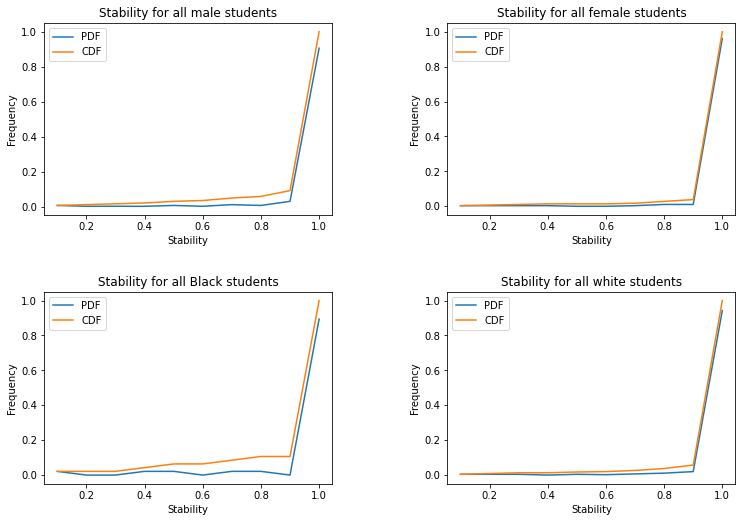

In [50]:
# plot stabilities of each subgroup
plt.figure(figsize=(12, 8))

plot_cdf(tiny_test.loc[tiny_test['Sex'] == 1], 'all male', 221)
plot_cdf(tiny_test.loc[tiny_test['Sex'] == 2], 'all female', 222)
plot_cdf(tiny_test.loc[tiny_test['Race'] == 3], 'all Black', 223)
plot_cdf(tiny_test.loc[tiny_test['Race'] == 4], 'all white', 224)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

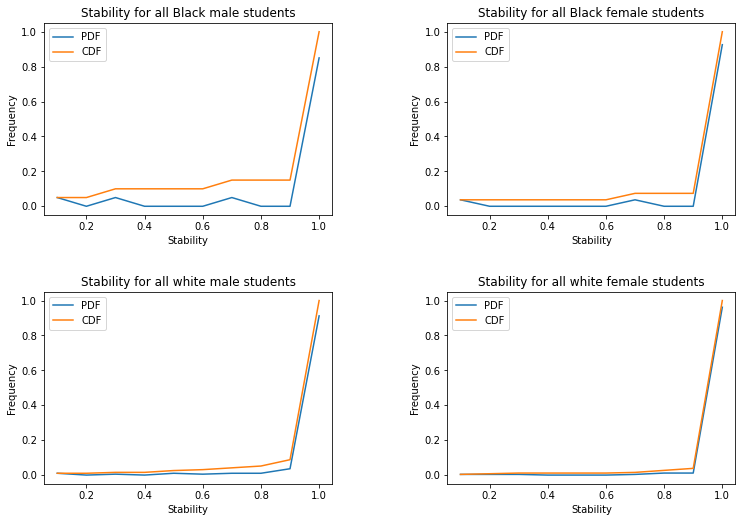

In [49]:
# plot stabilities of each intersectional subgroup
plt.figure(figsize=(12, 8))

plot_cdf(tiny_test.loc[(tiny_test['Sex'] == 1) & (tiny_test['Race'] == 3)], 'all Black male', 221) 
plot_cdf(tiny_test.loc[(tiny_test['Sex'] == 2) & (tiny_test['Race'] == 3)], 'all Black female', 222)
plot_cdf(tiny_test.loc[(tiny_test['Sex'] == 1) & (tiny_test['Race'] == 4)], 'all white male', 223)
plot_cdf(tiny_test.loc[(tiny_test['Sex'] == 2) & (tiny_test['Race'] == 4)], 'all white female', 224)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)